<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module4/Retrieval_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LangChain Retrievers**

In [2]:
# Updated for February 2026 stability
!pip install -qU \
    langchain \
    langchain-core \
    langchain-community \
    langchain-google-genai \
    langchain-chroma \
    langchain-classic \
    langchain-text-splitters \
    pypdf


import os
from google.colab import userdata

# API Key from Colab Secrets
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


# **Data Preparation: Loading & Splitting**

* **PDF Source File**: https://digitate.com/wp-content/uploads/2025/12/Agentic-AI-and-the-Future-of-Enterprise-IT-Report-1.pdf


* The **Digitate 2025/2026**  report is a document for enterprise-grade Agentic AI. It  provides data on how companies are actually deploying these systems in production right now.

*  We first need to implement the **Ingestion phase** of the RAG pipeline. It takes the raw PDF and transforms it into a **searchable mathematical database.**

* **PyPDFLoader** fetches a PDF from a URL or local path and extract its text content.

* **loader.load()** creates a list of **Document** objects where each object represents **one page of the PDF**

* **RecursiveCharacterTextSplitter**:
  * LLMs have a limit on how much text they can process at once. Additionally, searching for a specific answer is more accurate if the data is broken into smaller pieces.

  * **chunk_size=1000** breaks the text into segments of roughly 1,000 characters each.

  * **chunk_overlap=150**  keeps 150 characters from the end of one chunk at the beginning of the next. This **contextual bridge** ensures that if a sentence is cut in half, the meaning is preserved in both chunks.


* **Summary of work flow:**
  * Raw PDF => Individual Pages => Small Text Chunks => Embedding Vectors => Searchable Database

In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter



# Load the Digitate 2026 Report
pdf_url = "https://digitate.com/wp-content/uploads/2025/12/Agentic-AI-and-the-Future-of-Enterprise-IT-Report-1.pdf"
loader = PyPDFLoader(pdf_url)
docs = loader.load()



# Split into chunks with a contextual bridge (overlap)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150
)
splits = text_splitter.split_documents(docs)

print(f"Document loaded and split into {len(splits)} chunks.")




Document loaded and split into 49 chunks.


# **Basic Vector Retrieval**


* The simplest form of retrieval: Find the **top-k most similar chunks**

* Here, we're looking at the **Retriever in isolation**. It's like testing a library's search engine before we actually reading the books.

* The retriever is a purely mathematical tool. It simply performs **a vector similarity search**:
  * It converts the question into an embedding vector
  * It looks through the database for the top k chunks of text whose vectors look the most similar to the question.
  * It hands those raw text chunks back.
  * No **thinking** is involved yet. This is why the output is just raw snippets of the PDF (the page_content).    

---
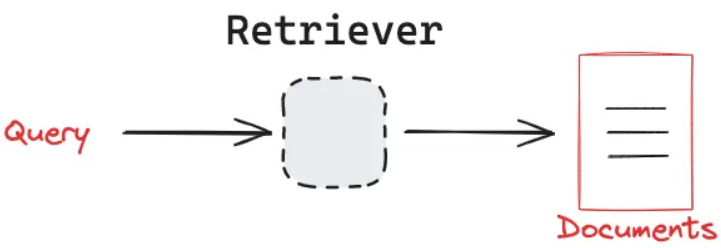
---
* **.as_retriever()**:
   * A VectorStore such as Chroma  is technically just a database.
  * By calling this method, we wrap it in a Retriever interface, which is a standardized LangChain object that takes a string (query) and returns a list of Documents.

---

* **search_kwargs={"k": 4}**:
   * This tells the retriever to return exactly the top 4 most similar text chunks or documents from the database.
   * If we change this to k: 5, we'll get more context but use more tokens.
---

 * **.invoke(query)**:
    * This is the modern way to run the search.
    * It sends the query to the Embedding Model to turn it into a vector.
    * It compares that query vector against every vector in your database.
    * It finds the **nearest neighbors** in vector space (the 4 chunks with the most similar meaning).
    * Finally, it returns a list of Document objects.  


In [9]:
import time
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma



# Initialize the 2026 flagship embedding model
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    task_type="RETRIEVAL_DOCUMENT",
    persist_directory="./chroma_db" # Added for consistency
)



# Initialize Chroma (using the modular 2026 syntax)
vectorstore = Chroma(
    collection_name="digitate_report_2026",
    embedding_function=embeddings
)


# Clear any old data
ids = vectorstore.get()['ids']
if ids:
    vectorstore.delete(ids=ids)
    print(f"Cleared {len(ids)} old entries from the vectorstore.")



# Batch upload with rate-limit protection (Mandatory for Free Tier)
batch_size = 50
print(f" Embedding {len(splits)} chunks...")

for i in range(0, len(splits), batch_size):
    batch = splits[i : i + batch_size]
    vectorstore.add_documents(batch)
    print(f" Indexed chunks {i} to {min(i + batch_size, len(splits))}")
    if i + batch_size < len(splits):
        time.sleep(15)



# --- RETRIEVER TEST SECTION ---

# Convert the vectorstore into a retriever
# k=4 remains the 2026 standard for high-density reports
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})



# Execute a test query
query = "What are the primary use cases for AI agents in the next 12 months?"
results = retriever.invoke(query)




# Print the results with enhanced Metadata (source tracking) formatting
print(f"\n Testing Retriever with query: '{query}'")

for i, doc in enumerate(results):
    # PyPDFLoader (pypdf) defaults to 0-indexed 'page'
    page_num = doc.metadata.get('page', 'Unknown')
    display_page = page_num + 1 if isinstance(page_num, int) else "Unknown"

    print(f"\n--- Result {i+1} | Source: Page {display_page} ---")

    # CLEANING: Replace multiple newlines/tabs with a single space for readability
    clean_content = " ".join(doc.page_content.split())

    # SNIPPET: Showing 350 chars (slightly more for 2026 technical analysis)
    print(f"Content: {clean_content[:350]}...")

    # OPTIONAL: Print the specific source file if metadata exists
    source_file = doc.metadata.get('source', 'Unknown File')
    if source_file != 'Unknown File':
        print(f"File: {source_file.split('/')[-1]}")

 Embedding 49 chunks...
 Indexed chunks 0 to 49

 Testing Retriever with query: 'What are the primary use cases for AI agents in the next 12 months?'

--- Result 1 | Source: Page 11 ---
Content: Top option for Manufacturing/ Automotive industries (67%) Top option for Retail/Ecommerce/ Transport/Hospitality industries (67%) Adoption is strongest within IT operations (67%), customer-support (46%) and automated reporting (44%)/software development (44%) functions -environments where complexity and data intensity demand adaptive, decision-orie...
File: Agentic-AI-and-the-Future-of-Enterprise-IT-Report-1.pdf

--- Result 2 | Source: Page 6 ---
Content: Section 1 The Current State of Enterprise AI 1.1 Adoption and Maturity Adoption of AI is now universal, but the story of maturity is one of evolution and differentiation. Every organization surveyed has implemented AI in the last two years, using an average of five AI tools across multiple functions. Generative AI remains the most widely deplo

# **Multi-Query Retrieval**

---
  * **gemini-2.5-flash-lite** is optimized for speed and high-throughput tasks like RAG, and it has a more generous free-tier quota than the heavier Pro models.

  * **temp=0** makes the model **deterministic** and not creative or poetic; it will give the most straightforward, factual answer possible based on the text.

---
* Sometimes one query isn't enough so we use Gemini to generate **multiple versions of the user's question** to find **better** matches.


* **MultiQueryRetriever.from_llm**
   * Standard RAG can fail if the user's question uses different words than the document. That's because **distance-based search**  is very sensitive to wording.
   
   * E.g., if the PDF uses the word **Profitability** but we search for **ROI (Return on Investment)**, a basic search might miss it

   * So, even though we don't write it out, this retreiver comes pre-packaged with a **hidden instruction** for the LLM that looks something like this:
     * **You are an AI language model assistant. Your task is to generate three different versions of the given user query to retrieve relevant documents from a vector database.**
   
   * For the query about **AI agent use cases and ROI,** the LLM might create formats like:

        1. What are the top priorities for AI agent implementation in 2026?

        2. How is the financial benefit of AI agents measured in the Digitate report?

        3. List the expected expansion areas for autonomous IT agents over the next year.
   
   * It then runs all 3 questions against the vector store, finds the top 3 results for each, and then merges them while removing duplicates.
   
   * This casts a wider net to ensure the right information is found.

   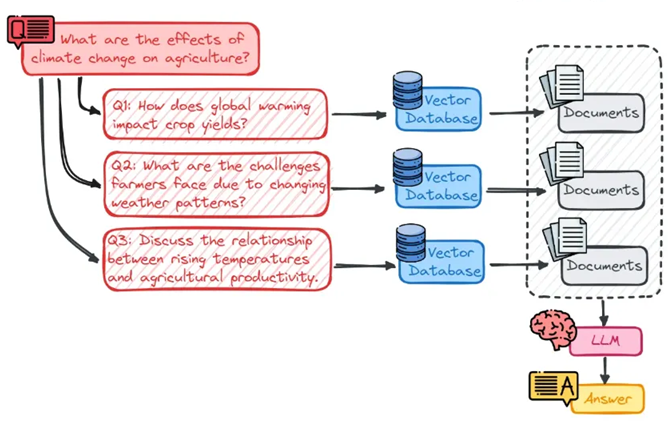

---
  * **ChatPromptTemplate.from_template**
     * This creates a blueprint for the final instructions sent to the AI.
     * {context} and {input} are **variables** that LangChain will fill automatically during the execution of the RAG chain.
---

* **create_stuff_documents_chain(llm, prompt)**
  * We need to connect individual AI tools into a single, automated workflow.
  * This line creates the **Answer Engine**
  * Its job is to take a list of documents and **stuff** them into the prompt template.
  * At this stage, the chain doesn't know how to search a database yet; it only knows how to answer a question if we give it a pile of text

---
* **create_retrieval_chain(retriever_mq, combine_docs_chain)**
  * This line creates the **Orchestrator.**
  * Its job is to connect the **Search Engine (the retriever)** to the **Answer Engine** we just built.
  * It sends the question to **retriever_mq**
  * It then waits for the retriever to find relevant chunks in the Bitcoin PDF.
  * It passes those chunks (as {context}) and the question (as {input}) into the **combine_docs_chain.**

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_classic.retrievers import MultiQueryRetriever
from langchain_classic.chains import create_retrieval_chain
from langchain_classic.chains.combine_documents import create_stuff_documents_chain



# Gemini 2.5 Flash Lite is the efficient choice for 2026 RAG
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0)



# Prompt: Using the standard "input" and "context" keys
prompt = ChatPromptTemplate.from_template("""
You are a 2026 IT Strategy Consultant. Use the provided context to answer the business query.
If the information is not in the context, state that you don't have enough data.

Question: {input}

Please answer the above using only these provided details:
{context}
""")



# MultiQuery Retriever: Using k=4 for dense technical reports
# This will generate those "multiple formats" automatically
retriever_mq = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(search_kwargs={"k": 4}),
    llm=llm
)



# Build the Chain (The modern 'Stuff' + 'Retrieval' pattern)
combine_docs_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever_mq, combine_docs_chain)




# Execute
print("Analyzing Digitate Report with Multi-Query Retrieval...")
try:
    query = "What are the primary use cases for AI agents in the next 12 months, and how does the report define the ROI of these implementations?"

    # We pass the query in the "input" key which rag_chain expects
    response = rag_chain.invoke({"input": query})

    print("\n--- CONSULTANT SUMMARY ---")
    print(response["answer"])

    # Optional: See which pages were used
    sources = sorted(list(set(doc.metadata.get("page", 0) + 1 for doc in response["context"])))
    print(f"\n Evidence found on Pages: {sources}")

except Exception as e:
    print(f" Error during execution: {e}")


Analyzing Digitate Report with Multi-Query Retrieval...

--- CONSULTANT SUMMARY ---
Based on the provided context, here are the answers to your business query:

**Primary use cases for AI agents in the next 12 months:**

The context does not explicitly state the primary use cases for AI agents in the *next 12 months*. However, it does provide insights into current and planned deployments:

*   **Current Strongest Adoption:** IT operations (67%), customer-support (46%), and automated reporting (44%)/software development (44%) functions.
*   **Current Most Successful Use Cases:** Enabling customer self-service (49%) and reporting & analytics (48%).
*   **Deployment Plans for 2026:** Continued expansion across nearly all IT domains, with particularly strong momentum in cost optimization (65%), proactive problem management (55%), and cybersecurity (53%).
*   **Industry-Specific Top Options:** Manufacturing/Automotive industries (67%) and Retail/Ecommerce/Transport/Hospitality industries (6